<a href="https://colab.research.google.com/github/AngelicaDC/BEDUpython/blob/main/Corrupt_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Importamos las librerias

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from seaborn import kdeplot
import folium

#### Preguntas para este analisis
- ¿Que tan eficiente es la metodologia de la ASF para elegir auditar las secciones correctas del presupuesto publico?
- ¿Existen patrones en la presencia de anomalias (dinero faltante) en el manejo de los recursos?
- ¿Que "caracterizticas" estan mejor relacionadas con la incidencia de interes en el presupuesto publico?
- ¿Es posible estimar las probabilidades de incidencia para las anomalias en el presupuesto segun algunas de las caracterizticas del dataset?
- ¿Existe algun impacto notable de la corrupcion en la calidad de vida medida por el CPI?
- ¿Considerando los datos obtendos por la ASF y la todalidad del presupuesto publico que tan grave y frecuente se ve proyectada la corrupcion en mexico?
- ¿Es posible comprender o identificar patrones a partir de los datos en la forma en la que la ASF decide a quien y cuando auditar?
- ¿Existe alguna relacion entre la cantidad de presupuesto destinado a una seccion y la valoracion del CPI para ese topico?
- ¿Existe alguna relacion entre la cantidad de presupuesto destinado a una seccion y la cantidad de "corrupcion" detectada y/o proyectada?

#### Cargamos los datasets

In [97]:
def renom_estados(name):
  estados = {
    'Michoacán de Ocampo': 'Michoacán', 
    'México': 'Estado de México', 
    'Veracruz Ignacio de la Llave': 'Veracruz',
    'Coahuila de Zaragoza': 'Coahuila'}

  if name in estados:
    return estados[name]
  
  return name

In [100]:
ds_cpi = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/CPI_Mex_full.csv')
ds_cpi['estado'] = ds_cpi['estado'].map(renom_estados)
ds_cpi.head(3)

,estado,municipio,Accesibilidad al espacio público abierto,Acceso a Internet,Acceso a agua mejorada,Aglomeración económica,CALIDAD DE VIDA,Calidad del aire,Capacidad institucional y ﬁnanzas municipales,Coeﬁciente de Gini,Concentraciones de material particulado,Concentración de CO2,Crecimiento económico,Densidad de la interconexión vial,Densidad de médicos,Densidad económica,Densidad poblacional,Densidad vial,Desempleo juvenil,Deuda subnacional,EQUIDAD E INCLUSIÓN SOCIAL,Educación,Empleo,Energía,Equidad económica,Espacio habitable suﬁciente,Espacio público,Esperanza de vida al nacer,Eﬁciencia del gasto local,Eﬁciencia en el uso de suelo,Fatalidades de tránsito,Forma urbana,GOBERNANZA Y LEGISLACIÓN URBANA,Gobernanza de la urbanización,INFRAESTRUCTURA DE DESARROLLO,Inclusión de género,Inclusión social,Infraestructura de comunicaciones,Infraestructura de vivienda,Infraestructura social,Inscripción equitativa en educación a nivel secundario,Longitud de transporte masivo,Manejo de residuos,Movilidad urbana,Número de estaciones de monitoreo,PRODUCTIVIDAD,Participación electoral,Participación y rendición de cuentas,Producto urbano per cápita,Promedio de años de escolaridad,Proporción de generación de energía renovable,Recaudación de ingresos propios,Recolección de residuos sólidos,Relación de dependencia de la tercera edad,Relación empleo-población,SOSTENIBILIDAD AMBIENTAL,Salud,Seguridad y protección,Superﬁcie destinada a vías,Tasa de alfabetización,Tasa de desempleo,Tasa de homicidios,Tasa de mortalidad de menores de 5 años,Tasa de pobreza,Tratamiento de aguas residuales,Velocidad de banda ancha promedio,Vivienda durable,Viviendas en barrios precarios,Áreas verdes per cápita
0,Aguascalientes,Aguascalientes,73.28,27.92,99.02,68.10,69.72,62.83,43.60,49.45,67.43,46.08,51.88,100.0,71.24,68.10,42.90,84.57,62.88,14.66,72.49,85.15,64.44,0.0,47.80,100.0,63.96,73.16,91.34,0.0,84.71,89.49,29.10,0.0,64.85,90.33,79.34,35.68,85.48,71.24,90.33,0.0,41.47,42.36,75.0,61.48,43.70,43.70,41.23,73.79,0.0,24.80,2.94,62.54,58.77,34.77,67.44,62.34,83.91,96.51,70.12,62.34,61.71,46.15,80.00,43.44,99.99,95.80,54.65
1,Aguascalientes,Jesús María,38.22,32.03,97.96,70.14,60.84,56.75,20.87,53.62,67.42,46.08,59.68,100.0,21.70,70.14,10.60,78.63,74.44,3.62,73.72,71.44,69.28,0.0,51.67,100.0,38.48,74.97,43.66,100.0,81.19,80.49,56.84,100.0,52.60,85.28,84.21,43.06,77.14,21.70,85.28,0.0,83.20,40.59,NaN,66.37,49.65,49.65,48.97,47.14,0.0,15.33,99.36,70.39,57.34,69.97,73.82,59.62,62.82,95.74,81.23,59.62,72.67,49.71,67.03,54.10,100.00,93.98,38.73
2,Aguascalientes,San Francisco de los Romo,100.00,8.40,98.42,65.86,62.71,56.75,37.20,60.70,67.43,46.08,60.89,100.0,27.90,65.86,12.31,87.82,69.52,0.00,72.67,75.79,64.59,0.0,47.86,100.0,58.96,73.16,100.00,0.0,77.64,88.00,29.81,0.0,51.66,87.23,82.93,25.92,77.68,27.90,87.23,0.0,35.36,38.82,NaN,63.78,52.23,52.23,51.47,57.57,0.0,11.61,2.24,70.31,55.52,30.70,64.17,51.93,76.19,94.02,73.66,51.93,55.17,35.02,68.48,43.44,100.00,96.33,17.93


In [ ]:
def get_money(text):

  if pd.isna(text):    
    return np.nan
  re_dinero = re.compile(r'monto de ([\d|,|\.]+) pesos')
  res = re_dinero.search(text)
  if res:
    re_num = re.compile(r'[^0-9]')
    return float(re.sub(re_num, '', res.groups()[0][:-3]))
  return np.nan

In [98]:
ds_asf = pd.read_csv(
    'https://raw.githubusercontent.com/Erick-INCS/Corruption-analysis/main/datasets/asf_2017-2019.csv',
     encoding='latin-1')
ds_asf['terminado'] = ds_asf['Estado de Trámite'].isin(['Con seguimiento concluido','Conclusión'])
ds_asf['desaparecido'] = ds_asf['Texto Acción'].apply(get_money)
ds_asf['Entidad Federativa'] = ds_asf['Entidad Federativa'].map(renom_estados)
ds_asf.head(2)

,Año Cuenta Pública,Grupo Funcional,Sector,Ente Fiscalizado,Entidad Federativa,Tipo Auditoría,Número,Título,Universo (miles pesos),Muestra (miles pesos),Ente a quien se dirige la Acción,Tipo Acción,Clave Acción,Acción Superveniente,Texto Acción,Estado de Trámite,Auditorías,Acciones,terminado,desaparecido
0,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Pliego de Observaciones,2019-1-19GYR-19-1393-06-001,-,"Se presume un probable daño o perjuicio, o amb...",En seguimiento,1,1,False,1.342933e+09
1,2019,Gasto Federalizado,Aportaciones A Seguridad Social,Instituto Mexicano del Seguro Social,Ciudad de México,De Cumplimiento,1393,Programa de Atención a la Salud y Medicamentos...,"1,342,933.00","1,342,933.00",Instituto Mexicano del Seguro Social,Promoción de Responsabilidad Administrativa Sa...,2019-9-19GYR-19-1393-08-001,-,La Auditoría Superior de la Federación emite l...,Con seguimiento concluido,1,1,True,NaN


In [99]:
df_pres = pd.read_parquet('https://github.com/Erick-INCS/Corruption-analysis/blob/main/datasets/presupuesto_2017-2020.parquet?raw=true')
df_pres['ENTIDAD_FEDERATIVA'] = df_pres['ENTIDAD_FEDERATIVA'].map(renom_estados)
df_pres.head(5)

,CICLO_RECURSO,PROGRAMA_FONDO_CONVENIO_ESPECIFICO,DESC_PARTIDA_GENERICA,DESC_TIPO_GASTO,ID_RAMO,MONTO_RECAUDADO,TRIMESTRE,MONTO_APROBADO,ID_PARTIDA_GENERICA,MONTO_EJERCIDO,MONTO_PAGADO,MONTO_DEVENGADO,MONTO_COMPROMETIDO,MONTO_MODIFICADO,TIPO_RECURSO,CICLO,DESC_RAMO,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCION_EJECUTORA
0,2008,FAM 2008,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,4.869210e+05,1,4.869210e+05,421,4.572240e+05,4.572240e+05,4.572240e+05,4.605600e+05,4.869210e+05,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
1,2010,FAM 2010,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,1.526132e+06,1,1.526132e+06,421,8.520000e+05,8.520000e+05,8.520000e+05,1.457215e+06,1.526132e+06,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
2,2012,SIN IDENTIFICAR,Sueldos base al personal permanente,Gasto corriente,33,3.564887e+08,1,3.564887e+08,113,3.564887e+08,3.564887e+08,3.564887e+08,3.564887e+08,3.564887e+08,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...
3,2012,SIN IDENTIFICAR,Honorarios asimilables a salarios,Gasto corriente,33,9.583701e+04,1,9.583701e+04,121,9.583701e+04,9.583701e+04,9.583701e+04,9.583701e+04,9.583701e+04,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...
4,2012,SIN IDENTIFICAR,Sueldos base al personal eventual,Gasto corriente,33,9.259750e+07,1,9.259750e+07,122,9.259750e+07,9.259750e+07,9.259750e+07,9.259750e+07,9.259750e+07,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...


#Postwork 1
1.   Promedio
2.   Mediana
3.   Media Truncada
4.   Desviación estándar
5.   Rango
6.  Percentiles 25 y 75 (por lo menos)
7.   Rango intercuartil

In [79]:
# Limpieza de data set ds_asf  len(ds_asf) = 32404
# Quitar las filas que no tengan dinero desaparecido
ds_asf.dropna(subset = ["desaparecido"], inplace=True) #len(ds_asf) = 5893

In [81]:
def describe_chido(df, columnas = []):
  if columnas:
    df = df[columnas]
  descripcion =df.describe()
  descripcion.loc['IQR'] = descripcion.loc['75%']-descripcion.loc['25%']
  df['desaparecido'].sort_values(ascending= True)
  descripcion.loc['media trunca'] = stats.trim_mean(df, .05)
  descripcion.loc['mediana'] = df.median()
  descripcion.loc['rango'] = df.max() - df.min()
  return descripcion

In [82]:
describe_chido(ds_asf,['desaparecido'])

,desaparecido
count,5.893000e+03
mean,3.730324e+07
std,2.101103e+08
min,5.300000e+01
25%,2.943610e+05
50%,1.734000e+06
75%,1.064514e+07
max,7.317874e+09
IQR,1.035078e+07
media trunca,1.091891e+07


# Postwork 2
* Utiliza boxplots para analizar la distribución de tus variables numéricas.
* Piensa acerca de cuáles son los valores típicos y atípicos y dónde están concentrados el grueso de tus datos.
* Utiliza el Score de Rango Intercuartílico para filtrar tus valores atípicos. Compara tus medianas, medias y desviaciones estándares antes y después de realizar la filtración y ve cuánto cambiaron.
* Utiliza tablas de frecuencia e histogramas para observar la distribución de tus variables. 
* Caracteriza cada una de las distribuciones usando los términos que aprendiste durante la sesión. Obtén medidas de asimetría y curtosis para ver qué tan alejadas de la distribución normal están tus variables.
* Utiliza gráficas de densidad para comparar una variable numérica que pueda ser segmentada en dos o más categorías. Usa esta técnica para entender mejor cómo están distribuidos tus datos en cada uno de los grupos presentes.

### Distribución de dinero desaparecido tomando en cuenta todos los valores

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


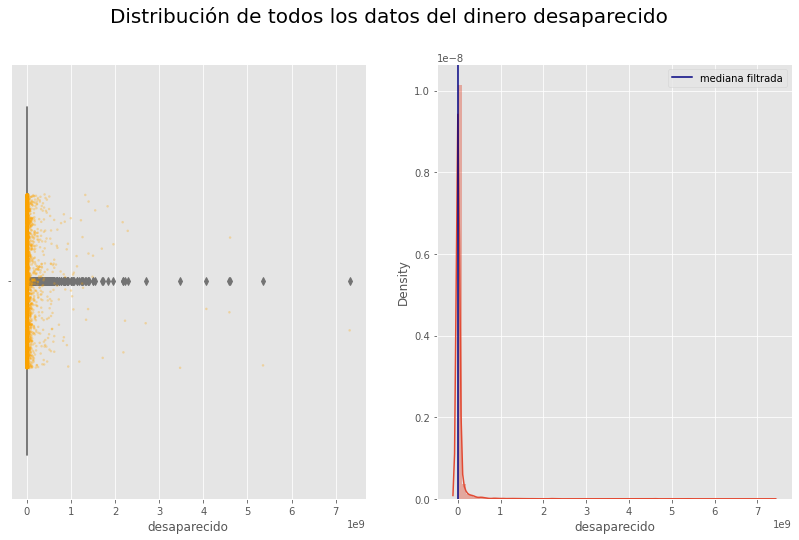

In [83]:
with plt.style.context('ggplot'):
  fig,axes=plt.subplots(1,2, figsize=(14,8));
  sns.boxplot(ds_asf['desaparecido'],ax=axes[0],color='lightskyblue', );
  sns.stripplot(ds_asf['desaparecido'], color="orange", ax=axes[0],jitter=0.2, size=2.5, alpha=0.3);
  plt.grid(True);
  sns.distplot(ds_asf['desaparecido'], rug=False, ax=axes[1], kde=True, norm_hist=False, bins=80);
  plt.axvline(ds_asf['desaparecido'].median(), color='navy', label='mediana filtrada')
  plt.legend()
  fig.suptitle('Distribución de todos los datos del dinero desaparecido', fontsize=20)
  plt.show();

In [ ]:
print('Curtosis:', ds_asf['desaparecido'].kurt())
print('Asimetría:', ds_asf['desaparecido'].skew())

Curtosis: 443.3492606731248
Asimetría: 17.77530799586359


Observamos que el grueso los valores está a la izquierda del eje x, necesitamos liberarnos de datos atípicos para observar mejor la distribución de los datos.

### Distribución del dinero desaparecido tomando en cuenta los valores filtrados con el score del rango intercuartílico

In [ ]:
iqr = ds_asf['desaparecido'].quantile(0.75) - ds_asf['desaparecido'].quantile(0.25)
filtro_inferior = ds_asf['desaparecido'] > ds_asf['desaparecido'].quantile(0.25) - (iqr * 1.5)
filtro_superior = ds_asf['desaparecido'] < ds_asf['desaparecido'].quantile(0.75) + (iqr * 1.5)
ds_asf2_filtrado = ds_asf[filtro_inferior & filtro_superior]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


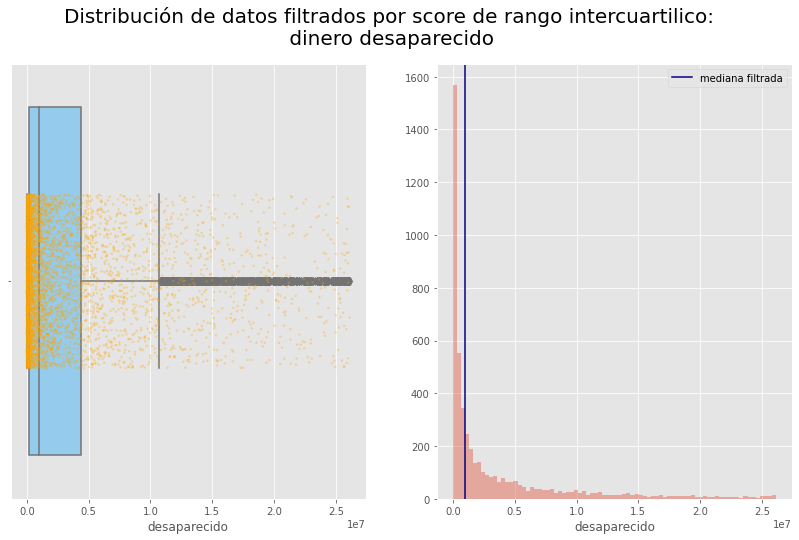

In [ ]:
with plt.style.context('ggplot'):
  fig,axes=plt.subplots(1,2, figsize=(14,8));
  sns.boxplot(ds_asf2_filtrado['desaparecido'],ax=axes[0],color='lightskyblue', );
  sns.stripplot(ds_asf2_filtrado['desaparecido'], color="orange", ax=axes[0],jitter=0.2, size=2.5, alpha=0.3);
  plt.grid(True);
  sns.distplot(ds_asf2_filtrado['desaparecido'], rug=False, ax=axes[1], kde=False, norm_hist=False, bins=80);
  #kdeplot(ds_asf2_filtrado['desaparecido'])
  plt.axvline(ds_asf2_filtrado['desaparecido'].median(), color='navy', label='mediana filtrada')
  plt.legend()
  fig.suptitle('Distribución de datos filtrados por score de rango intercuartilico:\n dinero desaparecido', fontsize=20)
  plt.show();

In [ ]:
print('Curtosis:', ds_asf2_filtrado['desaparecido'].kurt())
print('Asimetría:', ds_asf2_filtrado['desaparecido'].skew())

Curtosis: 4.264524810654861
Asimetría: 2.150649872676905


Los valores del dinero desaparecido siguen estando agrupados a la izquierda de la gráfica. Ambas gráficas tienen una asimetría derecha o positiva.

#### Análisis
Al inicio, el rango entre los datos era de 7.3x10^9, después de hacer la filtración por el score del rango intercuartílico, el rango bajó dos órdenes de magnitud, y la mediana pasó de tener magnitud de 10^6 a 10^5. 
Debido a que el rango sigue siendo muy grande, la desviación estándar también es muy grande. Como el set de datos nos habla de dinero perdido por corrupción, más vale que sigamos guardando registro de los outliers más grandes.
Por otro lado, la forma de las gráficas tanto con todos los datos como sólo con los del rango intercuartílico tienen una forma de gráfica exponencial (asimetría a la derecha), lo cual es coherente con el rango de cantidades que trabajamos en este estudio.

In [ ]:
print("Con valores atípicos\n", describe_chido(ds_asf,['desaparecido'])), 
print("\nSin valores atípicos\n", describe_chido(ds_asf2_filtrado,['desaparecido']))

Con valores atípicos
               desaparecido
count         5.893000e+03
mean          3.730324e+07
std           2.101103e+08
min           5.300000e+01
25%           2.943610e+05
50%           1.734000e+06
75%           1.064514e+07
max           7.317874e+09
IQR           1.035078e+07
media trunca  1.091891e+07
mediana       1.734000e+06
rango         7.317874e+09

Sin valores atípicos
               desaparecido
count         4.951000e+03
mean          3.544707e+06
std           5.453374e+06
min           5.300000e+01
25%           2.120090e+05
50%           9.887860e+05
75%           4.409691e+06
max           2.612366e+07
IQR           4.197682e+06
media trunca  2.761039e+06
mediana       9.887860e+05
rango         2.612360e+07


### Tabla de frecuencias y gráficas de barras

In [ ]:
#Como el rango de los datos es muy grande, tenemos que segmentarlos por órdenes de magnitud
bins = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
names = ["10-100","101-1000", "1000-1e4", "1e4-1e5", "1e5-1e6","1e6-1e7","1e7-1e8","1e8-1e9","1e9-1e10"]
segmentos = pd.cut(ds_asf['desaparecido'], bins, labels = names)
Frecuencias = ds_asf['desaparecido'].groupby(segmentos).count()
Frecuencias

desaparecido
10-100         2
101-1000       8
1000-1e4      84
1e4-1e5      616
1e5-1e6     1779
1e6-1e7     1876
1e7-1e8     1134
1e8-1e9      359
1e9-1e10      35
Name: desaparecido, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


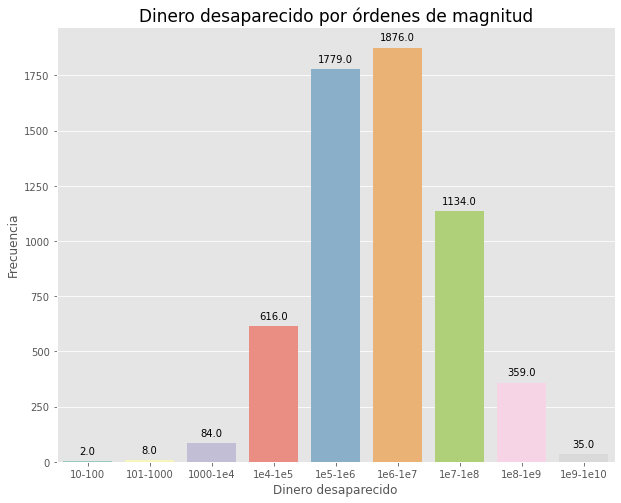

In [ ]:
with plt.style.context('ggplot'):
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot()
  ax = sns.barplot(names, Frecuencias, palette="Set3")
  ax.set_title('Dinero desaparecido por órdenes de magnitud', size=17)
  ax.set(ylabel='Frecuencia', xlabel='Dinero desaparecido')
  for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points');

#### Análisis
Observamos que la mayoria de los datos sobre cantidades de dinero desaparecido están entre 10,000 a 1,000,000,000 de pesos. Hay 35 casos donde el dinero desaparecido supera los miles de millones de pesos.

### Pendiente, tratar datos del dataset de gastos df_pres.
Podriamos encontrar una correlacion entre los estados donde hay mayor diferencia de dinero y donde encontramos mayor corrupcion en un determinado anio.

In [ ]:
df_pres.head(3)

,CICLO_RECURSO,PROGRAMA_FONDO_CONVENIO_ESPECIFICO,DESC_PARTIDA_GENERICA,DESC_TIPO_GASTO,ID_RAMO,MONTO_RECAUDADO,TRIMESTRE,MONTO_APROBADO,ID_PARTIDA_GENERICA,MONTO_EJERCIDO,MONTO_PAGADO,MONTO_DEVENGADO,MONTO_COMPROMETIDO,MONTO_MODIFICADO,TIPO_RECURSO,CICLO,DESC_RAMO,ENTIDAD_FEDERATIVA,MUNICIPIO,INSTITUCION_EJECUTORA
0,2008,FAM 2008,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,486921.0,1,486921.0,421,457224.0,457224.0,457224.0,460560.0,486921.0,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
1,2010,FAM 2010,Transferencias otorgadas a entidades paraestat...,Gasto de Inversión,33,1526132.0,1,1526132.0,421,852000.0,852000.0,852000.0,1457215.0,1526132.0,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,FISICA EDUCATIVA INSTITUTO DE INFRAESTRUCTURA
2,2012,SIN IDENTIFICAR,Sueldos base al personal permanente,Gasto corriente,33,356488747.2,1,356488747.2,113,356488747.2,356488747.2,356488747.2,356488747.2,356488747.2,"FEDERALES (APORTACIONES, SUBSIDIOS Y CONVENIOS)",2017,Aportaciones Federales para Entidades Federati...,Aguascalientes,Gobierno de la Entidad,INSTITUTO DE SERVICIOS DE SALUD DEL ESTADO DE ...


In [ ]:
len(df_pres)

823521

In [ ]:
# Monto aprobado es igual al monto pagado. El monto aprobado podriamos reemplazarlo por el comprmetido
((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) ==0).sum()  *100/len(df_pres)

15.575194803775496

In [ ]:
# Monto aprobado es diferente al monto pagado
((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) !=0).sum()  *100/len(df_pres)

84.4248051962245

In [ ]:
serie_AP = pd.Series((df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']))
serie_AP_rel = pd.Series((df_pres['MONTO_APROBADO']/df_pres['MONTO_PAGADO']))

In [ ]:
serie_AP_neg = pd.Series(serie_AP[(df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) < -1000000])
serie_AP_pos = pd.Series(serie_AP[(df_pres['MONTO_APROBADO'] - df_pres['MONTO_PAGADO']) > 1000000])

In [ ]:
len(serie_AP_neg), len(serie_AP_pos)

(40517, 127956)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/li

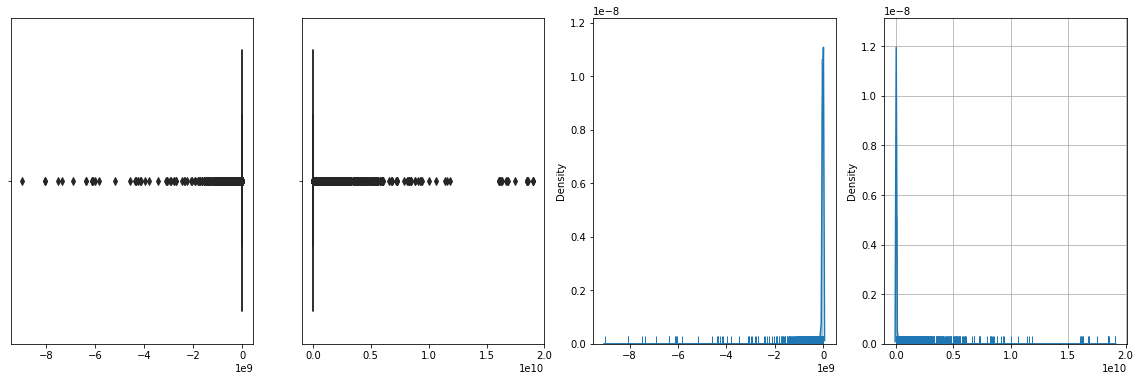

In [ ]:
fig,axes=plt.subplots(1,4, figsize=(20,6));
sns.boxplot(serie_AP_neg,color='purple', ax=axes[0]);
sns.boxplot(serie_AP_pos,color='purple', ax=axes[1]);
plt.grid(True);
sns.distplot(serie_AP_neg, rug=True, ax=axes[2], kde=True, norm_hist=False, bins=100);
sns.distplot(serie_AP_pos, rug=True, ax=axes[3], kde=True, norm_hist=False, bins=100); 


In [ ]:
serie_AP

0           29697.0
1          674132.0
2               0.0
3               0.0
4               0.0
            ...    
823516          0.0
823517          0.0
823518    -200000.0
823519    -400000.0
823520    1855853.0
Length: 823521, dtype: float64

In [ ]:
serie_AP.describe()

count    8.235210e+05
mean     4.487052e+06
std      1.276787e+08
min     -8.995841e+09
25%     -1.749000e+01
50%      9.201930e+03
75%      2.726182e+05
max      1.904910e+10
dtype: float64

In [ ]:
serie_AP_neg.describe()

count    4.051700e+04
mean    -2.363966e+07
std      1.696032e+08
min     -8.995841e+09
25%     -1.004768e+07
50%     -3.576766e+06
75%     -1.760774e+06
max     -1.000000e+06
dtype: float64

In [ ]:
serie_AP_pos.describe()

count    1.279560e+05
mean     3.607616e+07
std      3.073458e+08
min      1.000000e+06
25%      1.916121e+06
50%      4.017134e+06
75%      1.195609e+07
max      1.904910e+10
dtype: float64

In [ ]:
# Filtrar diferencias por rango intercurtilico
print('rango: ', serie_AP_pos.max() - serie_AP_pos.min())
iqr_AP_pos =  serie_AP_pos.quantile(0.75) -  serie_AP_pos.quantile(0.25)
filtro_inferior =  serie_AP_pos >  serie_AP_pos.quantile(0.25) - (iqr_AP_pos * 1.5)
filtro_superior =  serie_AP_pos <  serie_AP_pos.quantile(0.75) + (iqr_AP_pos * 1.5)
AP_pos_filtrado = serie_AP_pos[filtro_inferior & filtro_superior]
print('rango intercuartilico: ', iqr_AP_pos)

rango:  19048099634.0
rango intercuartilico:  10039964.815000001


In [ ]:
len(AP_pos_filtrado), len(serie_AP_pos)

(110035, 127956)

In [ ]:
AP_pos_filtrado.max() - AP_pos_filtrado.min()

26015184.189999998

In [ ]:
segmentos = pd.cut(AP_pos_filtrado, 100)
serie_AP_pos_segm= pd.Series(AP_pos_filtrado.groupby(segmentos).count())

In [ ]:
serie_AP_pos_segm

(973984.816, 1260151.842]       11849
(1260151.842, 1520303.684]       9448
(1520303.684, 1780455.526]       7232
(1780455.526, 2040607.368]       7005
(2040607.368, 2300759.21]        5155
                                ...  
(25714424.98, 25974576.822]       141
(25974576.822, 26234728.664]      166
(26234728.664, 26494880.506]      152
(26494880.506, 26755032.348]      157
(26755032.348, 27015184.19]       147
Length: 100, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


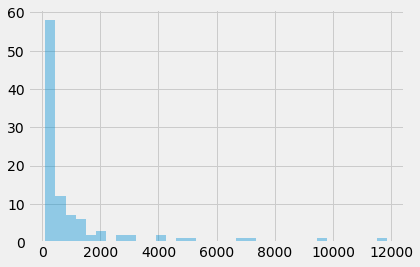

In [ ]:
plt.style.use('fivethirtyeight')
sns.distplot(serie_AP_pos_segm, kde=False, norm_hist=False);

In [ ]:
serie_AP_pos_sort=AP_pos_filtrado.sort_values(ascending= True)

In [ ]:
serie_AP_pos_sort.head(100).tail(20)

434446    1000908.24
320930    1000912.00
641140    1000928.00
554266    1000928.00
607740    1000949.12
518209    1000949.12
697703    1000949.12
232308    1000990.77
232305    1000990.77
323873    1000990.77
422172    1000990.77
515585    1000990.77
782512    1000997.49
572597    1001000.00
658834    1001000.00
749910    1001000.00
144107    1001032.84
562474    1001049.73
611466    1001090.36
173833    1001133.59
dtype: float64

In [ ]:
len(serie_AP_pos_sort)

110035

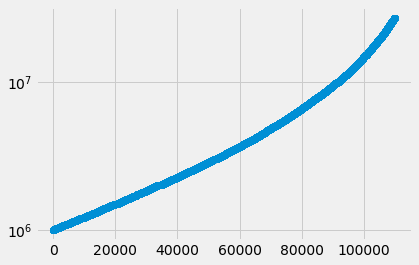

In [ ]:
import matplotlib.pyplot as plt
plt.semilogy(list(range(0,len(serie_AP_pos_sort))), serie_AP_pos_sort, marker='o', ls="") 
plt.show()

In [ ]:
serie_AP_pos_sort.kurtosis(), serie_AP_pos_sort.var(), serie_AP_pos_sort.skew()

(2.735346960363187, 31224959481286.99, 1.796846309818914)

# Postwork 3
1. Identifica todas las variables categóricas en tu dataset.
2. Utiliza gráficas de barras para explorar la distribución de tus variables categóricas.
3. Planea tu análisis multivariable: ¿qué combinaciones de variables categóricas podrían darme información útil acerca de la distribución de mis datos? ¿qué combinaciones de una variable numérica con una variable categórica podrían ser interesantes?
4. Utiliza tablas de contingencia y múltiples gráficas en la misma figure para explorar combinaciones de variables categóricas.
5. Utiliza boxplots y violinplots para explorar combinaciones de variables numéricas con variables categóricas.
6. De preferencia ve registrando por escrito (ahí mismo en tu Notebook) todos tus hallazgos. Describe qué vas descubriendo y qué podría significar.

##### Empezamos definiendo las variables categoricas como tal

In [ ]:
ds_asf['Sector'] = ds_asf['Sector'].astype('category')
ds_asf['Ente Fiscalizado'] = ds_asf['Ente Fiscalizado'].astype('category') ## Aqui hay muchas :|
ds_asf['Entidad Federativa'] = ds_asf['Entidad Federativa'].astype('category')
ds_asf['Tipo Auditoría'] = ds_asf['Tipo Auditoría'].astype('category')
ds_asf['Ente a quien se dirige la Acción'] = ds_asf['Ente a quien se dirige la Acción'].astype('category')
ds_asf['Tipo Acción'] = ds_asf['Tipo Acción'].astype('category')
ds_asf['Estado de Trámite'] = ds_asf['Estado de Trámite'].astype('category')
ds_asf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5893 entries, 0 to 32397
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Año Cuenta Pública                5893 non-null   int64   
 1   Grupo Funcional                   5893 non-null   object  
 2   Sector                            5893 non-null   category
 3   Ente Fiscalizado                  5893 non-null   category
 4   Entidad Federativa                5893 non-null   category
 5   Tipo Auditoría                    5893 non-null   category
 6   Número                            5893 non-null   int64   
 7   Título                            5893 non-null   object  
 8   Universo (miles pesos)            5893 non-null   object  
 9   Muestra (miles pesos)             5893 non-null   object  
 10  Ente a quien se dirige la Acción  5893 non-null   category
 11  Tipo Acción                       5893 non-null   categ

In [ ]:
def barplot(serie, title, xlabel, ylabel, rotation=0, axis=None):
  counts = serie.value_counts()
  ax = sns.barplot(y=counts.index, x=counts, ax=axis)
  ax.set_title(title)
  ax.set(ylabel=ylabel, xlabel=xlabel)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation);

In [ ]:
ds_asf['Sector'] = ds_asf['Sector'].cat.rename_categories({'Previsiones y Aportaciones Para Los Sistemas de Educación Básica, Normal, Tecnológica y de Adultos':'Aportaciones para Educación'})

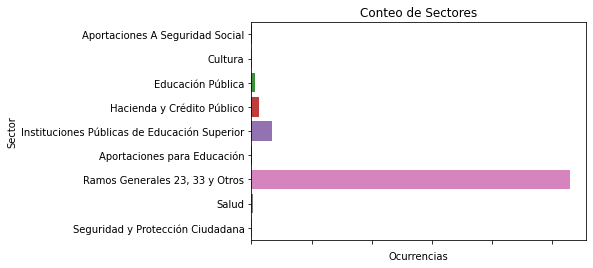

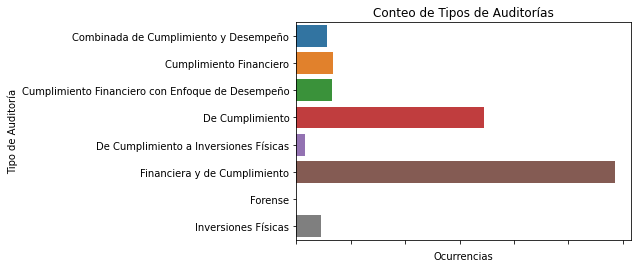

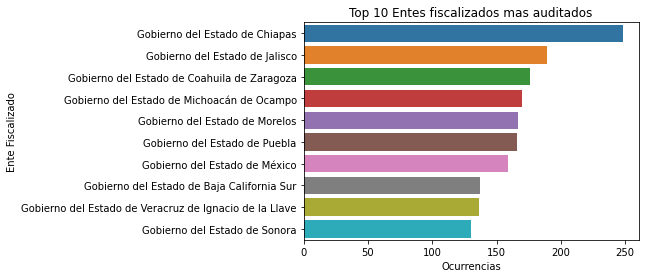

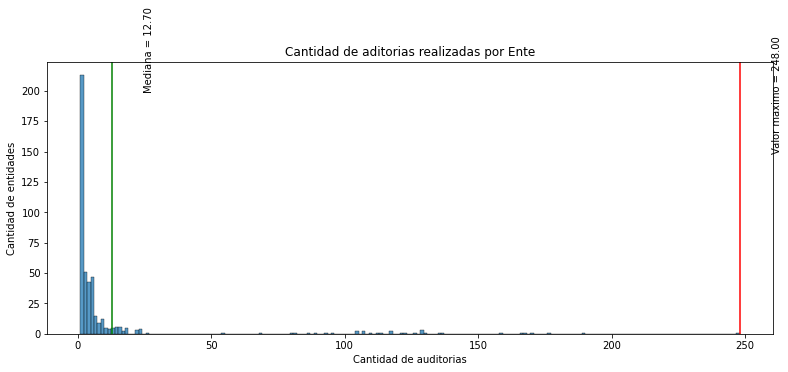

In [ ]:
barplot(ds_asf['Sector'], 
        title='Conteo de Sectores', 
        ylabel='Sector', 
        xlabel='Ocurrencias')
plt.show(); print()

barplot(ds_asf['Tipo Auditoría'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

serie_entes = ds_asf['Ente Fiscalizado'].value_counts()
top10 = serie_entes.sort_values(ascending=False)[:10].reset_index().values
ax = sns.barplot(y=top10[:,0], x=top10[:,1])
ax.set_title('Top 10 Entes fiscalizados mas auditados')
ax.set(xlabel='Ocurrencias', ylabel='Ente Fiscalizado')
plt.show(); print()

plt.figure(figsize=(13, 5))
plt.title('Cantidad de aditorias realizadas por Ente')
plt.ylabel('Cantidad de entidades')
plt.xlabel('Cantidad de auditorias')
sns.histplot(serie_entes)

span=12
plt.axvline(serie_entes.mean(), color='g')
plt.text(
    serie_entes.mean() + span,
    200,
    f'Mediana = {serie_entes.mean():.2f}',
    rotation=90)

plt.axvline(serie_entes.max(), color='r')
plt.text(
    serie_entes.max() + span, 150,
    f'Valor maximo = {serie_entes.max():.2f}',
    rotation=90);

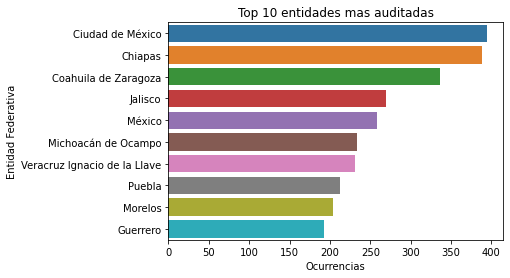

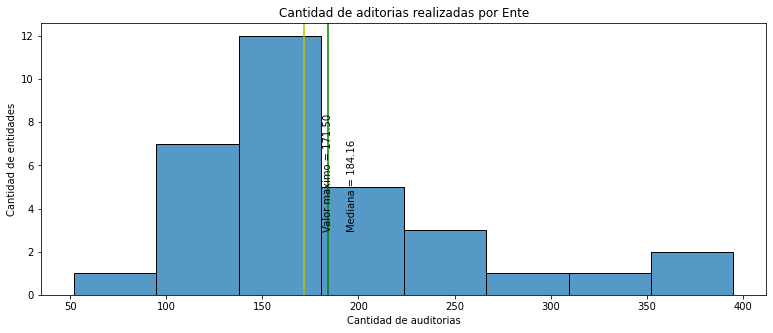

In [ ]:
serie_entidad = ds_asf['Entidad Federativa'].value_counts()
top10 = serie_entidad.sort_values(ascending=False)[:10].reset_index().values
ax = sns.barplot(y=top10[:,0], x=top10[:,1])
ax.set_title('Top 10 entidades mas auditadas')
ax.set(xlabel='Ocurrencias', ylabel='Entidad Federativa')
plt.show(); print()

plt.figure(figsize=(13, 5))
plt.title('Cantidad de aditorias realizadas por Ente')
plt.ylabel('Cantidad de entidades')
plt.xlabel('Cantidad de auditorias')
sns.histplot(serie_entidad)

span=10
plt.axvline(serie_entidad.mean(), color='g')
plt.text(
    serie_entidad.mean() + span,
    3,
    f'Mediana = {serie_entidad.mean():.2f}',
    rotation=90)

plt.axvline(serie_entidad.median(), color='y')
plt.text(
    serie_entidad.median() + span, 
    3,
    f'Valor maximo = {serie_entidad.median():.2f}',
    rotation=90);

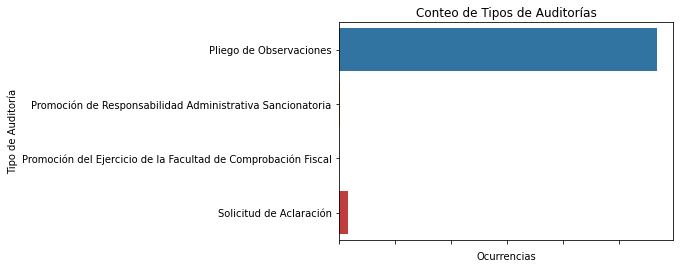

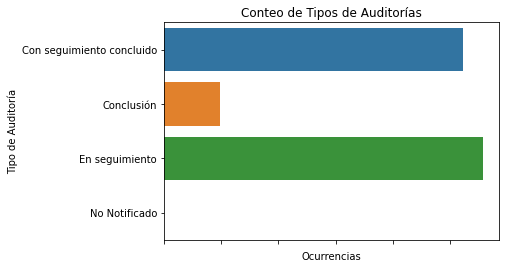

In [ ]:
barplot(ds_asf['Tipo Acción'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

barplot(ds_asf['Estado de Trámite'], 
        title='Conteo de Tipos de Auditorías', 
        ylabel='Tipo de Auditoría', 
        xlabel='Ocurrencias')
plt.show(); print()

# Postwork 4
Utilizando tu dataset, realiza las siguientes actividades:

* Identifica cuáles son las variables numéricas en tu dataset.
* Asegúrate de que tengan el tipo de dato correcto y que no haya NaNs por ahí escondidos.
* Genera una matriz de correlaciones y un pairplot para visualizar de manera general las relaciones entre tus variables numéricas.
* Utilizando gráficas de dispersión y tus medidas de locación y dispersión, identifica dónde hay valores atípicos y decide qué hacer con ellos.
* Revisa si tu revisión de valores atípicos cambió de alguna manera las relaciones existentes.
* Donde consideres necesario, entrena modelos de Regresión Lineal con un o más pares de variables. Incluso si no te parece que realizar predicciones entre pares de variables tiene sentido para tu proyecto, prueba realizar un par de regresiones para que practiques el procedimiento.

### Heatmap del CPI reducido a los rubros principales 
Coeficiente de correlación de pearson

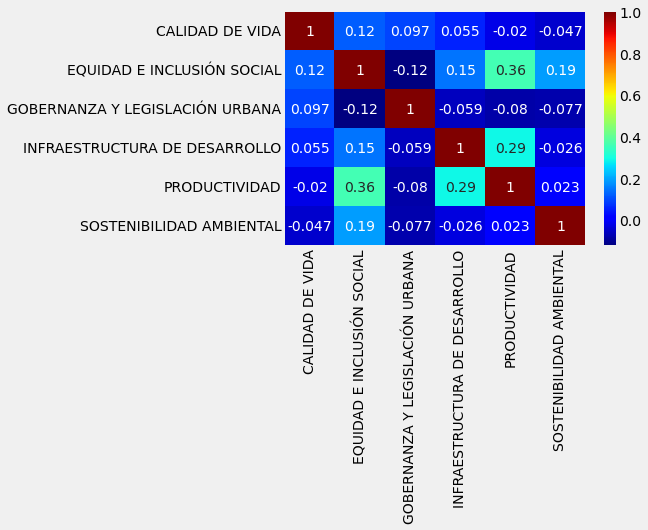

In [ ]:
ds_cpi_reducido =  ds_cpi[
                          list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]
ds_cpi_reducido = ds_cpi_reducido.set_index('estado')
ds_cpi_reducido

sns.heatmap(ds_cpi_reducido.corr(),cmap='jet', annot=True)

### Heatmap de todos los rubros
Coeficiente de correlación de pearson

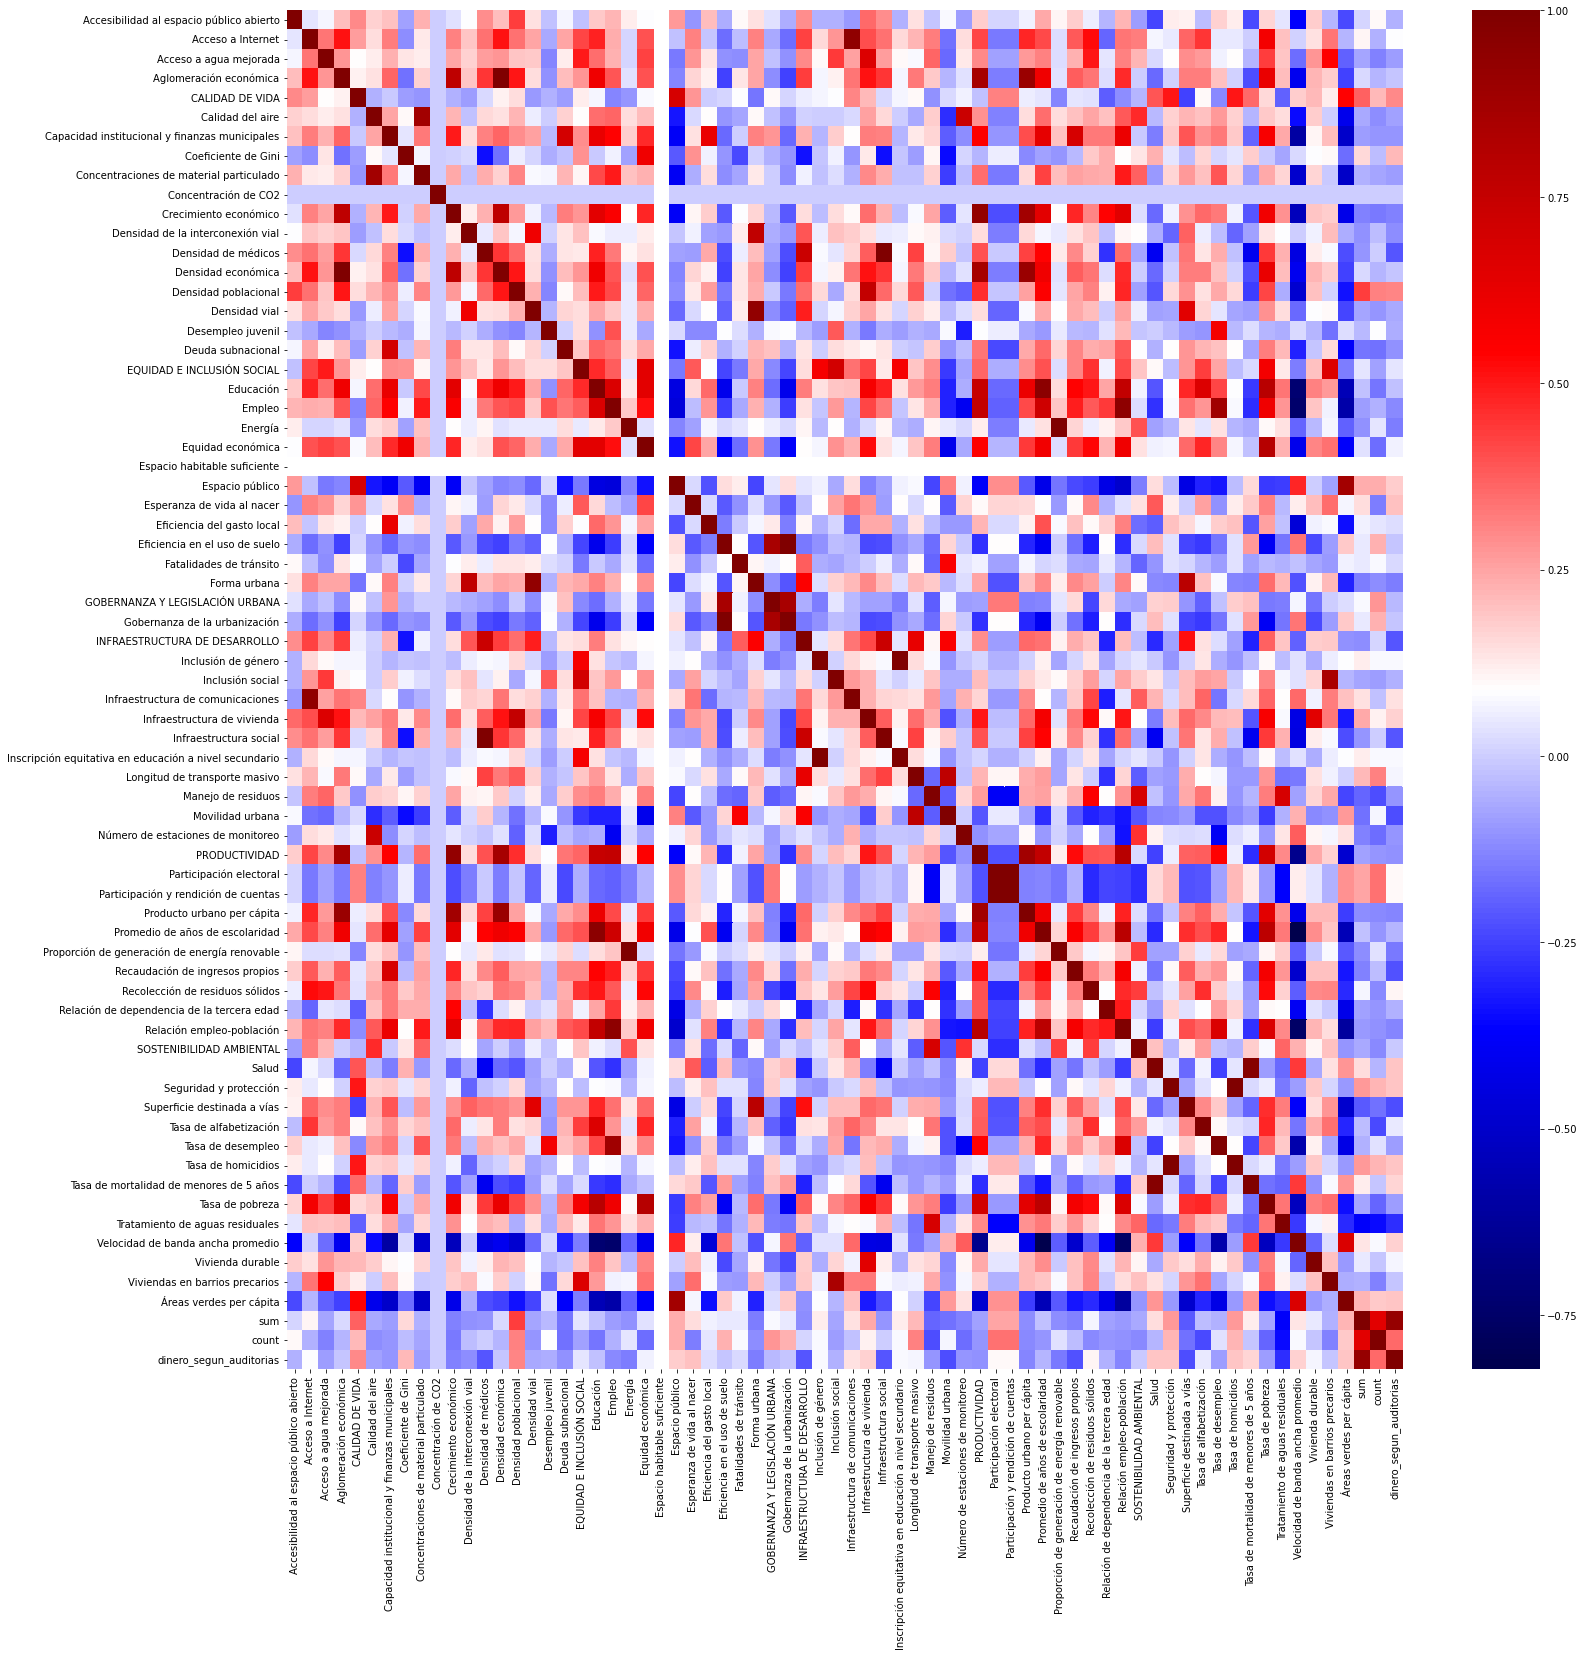

In [115]:
#Calculamos el dinero desaparecido por estado
dinero_por_estado = ds_asf.groupby(['Entidad Federativa'])['desaparecido'].aggregate(['sum', 'count'])
dinero_por_estado = dinero_por_estado.reset_index()
dinero_por_estado['dinero_segun_auditorias'] = dinero_por_estado['sum'] / dinero_por_estado['count']
dinero_por_estado  = dinero_por_estado.set_index('Entidad Federativa')

#Hacemos un merge para unir la información del dinero desaparecido por estado y los índices del CPI
cpi_dinero = pd.merge(ds_cpi, dinero_por_estado, left_on='estado', right_index=True).sort_index()
fig = plt.figure(figsize=(25,25))
sns.heatmap(cpi_dinero.corr(), cmap='seismic')

#### Análisis
Encontramos que la correlación positiva entre la suma del dinero perdido por estado es mayor con el rubro de "Densidad poblacional" del CPI, y la correlación negativa más grande la tiene con el rubro "Tratamiento de aguas residuales" del CPI.

Podemos observar que el número de auditorias por estado "count", también tiene una correlación positiva con los rubros de "Densidad poblacional", "Participación electoral" y "Participación y rendición de cuentas" del CPI. Y su mayor correlación negativa es con "Tratamiento de aguas residuales".

El dinero desaparecido por auditorias tiene una mayor correlación positiva con el rubro de "Densidad poblacional" y una mayor correlación negativa con "Tratamiento de aguas residuales".

Por lo tanto podríamos concluir que el rubro de densidad poblacional es la variable numérica que más se relaciona con la cantidad de dinero desaparecido por estado.

#PostWork 6

Graficamos los estados de la republica con su respectiva suma de dinero perdido

Obtenemos el dinero por perdido por estado


In [ ]:
dinero_por_estado = ds_asf.dropna(subset=['desaparecido'], how='any').groupby(['Entidad Federativa'])['desaparecido'].aggregate(['sum', 'count'])
dinero_por_estado = dinero_por_estado.reset_index()
dinero_por_estado['dinero_segun_auditorias'] = dinero_por_estado['sum'] / dinero_por_estado['count']
dinero_por_estado

### Falta el crolopletico del CPI


In [110]:
ds_cpi_reducido =  ds_cpi[    list(filter(
                              lambda cl: cl == cl.upper(),
                              ds_cpi.columns)) + ['estado']]

ds_cpi_reducido = ds_cpi_reducido.set_index('estado').join(dinero_por_estado.set_index('Entidad Federativa')).reset_index().rename(columns={'index':'estado'})
df_cpi_GobLeg = ds_cpi_reducido.groupby('estado')['GOBERNANZA Y LEGISLACIÓN URBANA'].aggregate(['mean'])
df_cpi_CV = ds_cpi_reducido.groupby('estado')['CALIDAD DE VIDA'].aggregate(['mean'])

df_cpi_GobLeg=df_cpi_GobLeg.reset_index()
df_cpi_CV=df_cpi_CV.reset_index()


In [119]:
mexico_json = "https://raw.githubusercontent.com/Forever-D14/DataScienceBEDU/main/Modulo%205%20-%20Python/Remoto%20mexico.json"

#df_cpi_GobLeg['estado'] = df_cpi_GobLeg['estado'].map(renom_estados)
#df_cpi_CV['estado'] = df_cpi_CV['estado'].map(renom_estados)
#dinero_por_estado['Entidad Federativa'] = dinero_por_estado['Entidad Federativa'].map(renom_estados)

dinero_por_estado['Dinero Perdido(MDP)']=dinero_por_estado['sum']/1_000_000_000

In [108]:
dinero_por_estado.to_csv('dinero_por_estado.csv')
df_cpi_GobLeg.to_csv('df_cpi_GobLeg.csv')
df_cpi_CV.to_csv('df_cpi_CV.csv')

In [109]:
m = folium.Map(location=[24.1245102,-103.4520039],zoom_start=5.46,)

##Cloropletico de Dinero Perdido
folium.Choropleth(
    geo_data = mexico_json,
    name='Dinero Perdido En México',
    data = dinero_por_estado,
    columns=['Entidad Federativa','Dinero Perdido(MDP)'],
    key_on='feature.properties.name',
    fill_color="YlGnBu",
    legend_name="Dinero Perdido MDP",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

##Cloropletico de Gobernanza y Legislación
folium.Choropleth(
    geo_data = mexico_json,
    name='Promedio de Gobernanza y Legislación Urbana',
    data = df_cpi_GobLeg,
    columns=['estado','mean'],
    key_on='feature.properties.name',
    fill_color="YlOrRd",
    legend_name="Puntos de Gobernanza y Legislación Urbana",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

##Cloropletico de Calidad de Vida
folium.Choropleth(
    geo_data = mexico_json,
    name='Promedio de Calidad de Vida',
    data = df_cpi_CV,
    columns=['estado','mean'],
    key_on='feature.properties.name',
    fill_color="Oranges",
    legend_name="Puntos de Calidad de Vida",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)


folium.LayerControl().add_to(m)

m

###Cloroplético de Densidad poblacional del CPI y comparación con dinero perdido por estado

In [128]:
df_cpi_densPob = cpi_dinero.groupby('estado')[['Densidad poblacional','sum','count','dinero_segun_auditorias']].max()
df_cpi_densPob=df_cpi_densPob.reset_index()

m = folium.Map(location=[23.7969798,-102.1413549],zoom_start=5.46,)

##Cloropletico de Densidad poblacional
folium.Choropleth(
    geo_data = mexico_json,
    name='Densidad poblacional',
    data = df_cpi_densPob,
    columns=['estado','Densidad poblacional',"dinero_segun_auditorias"],
    key_on='feature.properties.name',
    fill_color="Oranges",
    legend_name="Densidad poblacional",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

##Cloropletico de Dinero Perdido
folium.Choropleth(
    geo_data = mexico_json,
    name='Dinero desaparecido por auditorias por estado',
    data = df_cpi_densPob,
    columns=['estado','dinero_segun_auditorias'],
    key_on='feature.properties.name',
    fill_color="YlGnBu",
    legend_name="dinero_segun_auditorias",
    highlight=True,
    fill_opacity=0.5
        ).add_to(m)

folium.LayerControl().add_to(m)

m